Hunter Bennett | Glass Lab | Kupffer Strains Project | May 03 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Clustered heatmap of differential peaks

In [11]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 500

# clustering packages
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [13]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [14]:
if not os.path.isdir('./h3k27ac_differential_clustermap/'):
    os.mkdir('./h3k27ac_differential_clustermap/')

### Import differential peaks

In [15]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    h3k27acDirectory+'/merged_peaks/diff_output.txt',
    h3k27acDirectory+'/merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [16]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [17]:
# set conversion between inches and mm
mm_conv = 25.4

# set significance thresholds
pval = 0.05
fc = 1

In [18]:
# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comp_dict:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]


5465


### Z-score by row for plotting

In [20]:
# z-score by row
sd = np.std(sig_peaks, 1)
mean = np.mean(sig_peaks, 1)
z_frame = sig_peaks.subtract(mean, axis='rows').divide(sd, axis='rows')
# z_frame.columns = z_frame.columns.str.split('_').str[0]

### We will cluster the z-score peaks because this yields a visually appealing plot

In [21]:
d2 = dist.pdist(z_frame)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


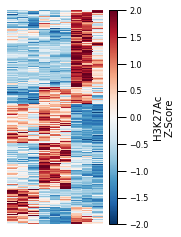

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(50/mm_conv, 100/mm_conv))

hm = sns.heatmap(z_frame.iloc[Z2['leaves'], :],
               # z_score=0,
                 xticklabels=0,
                 yticklabels=0,
                 vmin=-2,
                 vmax=2,
                 cmap='RdBu_r',
                 cbar=False,
                 ax=ax)

ax.set_ylabel('', fontsize=10)  

# # Create colorbar
cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap='RdBu_r'),
                  ax=ax,
                  use_gridspec=True,
                  shrink=1,
                  pad=0.05,
                  fraction=0.075,
                  aspect=26)
cb.ax.tick_params(labelsize=8)
cb.set_label('H3K27Ac\nZ-Score', fontsize=10, rotation=90)
plt.savefig('./h3k27ac_differential_clustermap/distal_peaks_clustered_heatmap.png',
            dpi=500,
            bbox_inches='tight')

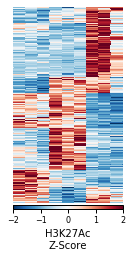

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(50/mm_conv, 100/mm_conv))

hm = sns.heatmap(z_frame.iloc[Z2['leaves'], :],
               # z_score=0,
                 xticklabels=0,
                 yticklabels=0,
                 vmin=-2,
                 vmax=2,
                 cmap='RdBu_r',
                 cbar=False,
                 ax=ax)

ax.set_ylabel('', fontsize=10)  

# # Create colorbar
cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap='RdBu_r'),
                  ax=ax,
                  use_gridspec=True,
                  orientation='horizontal',
                  shrink=1,
                  pad=0.01,
                  fraction=0.075,
                  aspect=26)
cb.ax.tick_params(labelsize=8)
cb.set_label('H3K27Ac\nZ-Score', fontsize=10)
plt.savefig('./h3k27ac_differential_clustermap/distal_peaks_clustered_heatmap_horiz_cbar.pdf',
            dpi=500,
            bbox_inches='tight')

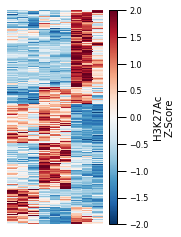

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(50/mm_conv, 100/mm_conv))

hm = sns.heatmap(z_frame.iloc[Z2['leaves'], :],
               # z_score=0,
                 xticklabels=0,
                 yticklabels=0,
                 vmin=-2,
                 vmax=2,
                 cmap='RdBu_r',
                 cbar=False,
                 ax=ax)

ax.set_ylabel('', fontsize=10)  

# # Create colorbar
cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap='RdBu_r'),
                  ax=ax,
                  use_gridspec=True,
                  shrink=1,
                  pad=0.05,
                  fraction=0.075,
                  aspect=26)
cb.ax.tick_params(labelsize=8)
cb.set_label('H3K27Ac\nZ-Score', fontsize=10, rotation=90)
# cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

plt.savefig('./h3k27ac_differential_clustermap/distal_peaks_clustered_heatmap.pdf',
            dpi=500,
            bbox_inches='tight')